In [1]:
import math
import random
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix
import sklearn.utils.class_weight
from sklearn import svm
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, BaggingRegressor, AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor
import pandas as pd
from imblearn.over_sampling import SMOTE 


Prepare the dataset


In [98]:
dataset=pd.read_csv("train_set.tsv",sep='\t',header=0)

#print(dataset["num_collisions"].value_counts(normalize=False))

X=dataset.iloc[:,:-2]  # : all raws :-2 slice out the last 2 columns
y=dataset.iloc[:,-2]   #just the last column

#normalized_df=(dataset-dataset.mean())/dataset.std()
Stdscaler = preprocessing.StandardScaler().fit(X)
X= Stdscaler.transform(X)
#X=(X-X.min())/(X.max()-X.min())  #between 0 and 1 (is column-wise)
#print(X.describe)
#print(X.std())
random_state=12
X,y=SMOTE(k_neighbors=2).fit_resample(X,y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=random_state) #to be reproducible
print(y_train.value_counts(normalize=False))



print("Number of training samples: %d" %(X_train.shape[0]))
print("Number of test samples: %d" %(X_test.shape[0]))


1    388
0    384
3    382
4    376
2    353
Name: num_collisions, dtype: int64
Number of training samples: 1883
Number of test samples: 807


GaussianNB

Input shape reduced train: (1883, 2)
Input shape reduced test: (807, 2)


Text(0.5, 1.0, 'Training and test samples')

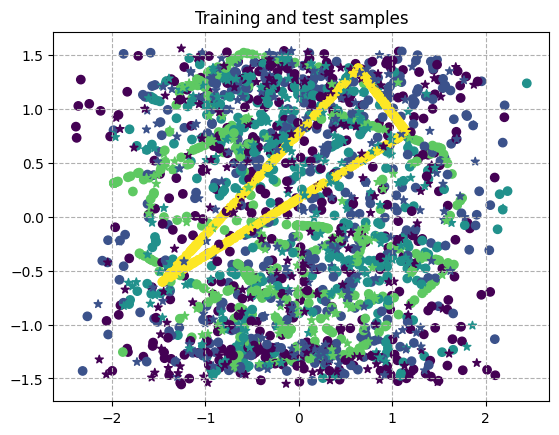

In [99]:
# select the first two features
X_train_reduced = X_train[:,2:4]
X_test_reduced = X_test[:,2:4]
print("Input shape reduced train: %s" %str(X_train_reduced.shape))
print("Input shape reduced test: %s" %str(X_test_reduced.shape))

plt.figure()
plt.scatter(X_train_reduced[:,0], X_train_reduced[:,1], c=y_train)
plt.scatter(X_test_reduced[:,0], X_test_reduced[:,1], c=y_test, marker="*")
plt.grid(linestyle="--")
plt.title("Training and test samples")

In [100]:
print(np.unique(y_train))
p=np.divide(y.value_counts().to_numpy(),y.shape[0])
print(p)
gen_model = GaussianNB()
gen_model.fit(X_train_reduced, y_train)



[0 1 2 3 4]
[0.2 0.2 0.2 0.2 0.2]


GaussianNB()

In [101]:
y_pred = gen_model.predict(X_test_reduced)
acc = accuracy_score(y_pred, y_test)    
print("Accuracy %.3f" %acc)
#0.553 with 0:2
#0.573 with 1:2
#0.580 with 2:4
#grid search to find best features


Accuracy 0.305


In [102]:
classifier=DecisionTreeClassifier(max_depth=25)
classifier.fit(X_train, y_train)
y_pred=classifier.predict(X_test)
acc = accuracy_score(y_pred, y_test)    
print("Accuracy %.3f" %acc)
print(sklearn.metrics.f1_score(y_test, y_pred,average=None))


Accuracy 0.741
[0.41666667 0.53125    0.80533333 0.87878788 0.99692308]


Ensemble of kernelized methods and simple methods with BOOSTING (trying to improve Aaccuracy)


In [106]:
classifier_name = 'D'
algorithm = 'SAMME.R' 
n_estimators=np.random.randint(5, 70, 5)

all_classifiers = {
    'G': [GaussianNB, 'Gaussian Naive Bayes'],
    'P': [Perceptron(), 'Perceptron'],
    'LR': [LogisticRegression, 'Logistic Regression'],
    'D': [DecisionTreeClassifier, 'Decision Tree'],
    'S': [svm.SVC, 'SVM']     
    }

#print(sklearn.utils.class_weight.compute_class_weight(class_weight='balanced', classes=np.array([0,1,2,3,4]), y=y))

boosting_params = {
  'learning_rate': np.random.uniform(size=5),
  'n_estimators': n_estimators,
  }

In [118]:

adaboost_classifier = AdaBoostClassifier(
    base_estimator=all_classifiers[classifier_name][0](max_depth=10),    #little less overfitting with max depth
    n_estimators=67, 
    learning_rate=0.9, 
    algorithm= algorithm, 
    random_state=random_state
    ).fit(X_train, y_train)

y_pred=adaboost_classifier.predict(X_test)
ada_accuracy_train = adaboost_classifier.score(X_train, y_train)  
ada_accuracy_test = adaboost_classifier.score(X_test,y_test)
print("Accuracy on train_set: %.3f" %ada_accuracy_train,"Accuracy on test_set: %.3f" %ada_accuracy_test)
print(sklearn.metrics.f1_score(y_test, y_pred,average=None))

Accuracy on train_set: 1.000 Accuracy on test_set: 0.872
[0.69360269 0.69032258 0.9541779  0.99358974 1.        ]


In [111]:
cv = KFold(n_splits=5, shuffle=True, random_state=random_state)
grid_search_boosting = GridSearchCV(
    adaboost_classifier,
    boosting_params, 
    scoring='accuracy', 
    cv=cv, 
    return_train_score=False,
    verbose=0
)
grid_search_boosting.fit(X_train, y_train)
#Best parameters for the classifier
print("Best classification hyper-parameters for boosting classifier: %r" %grid_search_boosting.best_params_)
print("Best accuracy: %.4f" %grid_search_boosting.best_score_)
print("Boosting Accuracy over the test set: %.4f" %grid_search_boosting.score(X_test, y_test))

Best classification hyper-parameters for boosting classifier: {'learning_rate': 0.8940062649506855, 'n_estimators': 67}
Best accuracy: 0.8237
Boosting Accuracy over the test set: 0.8674


Bagging

In [94]:
bagging_params = {
  'max_samples': np.random.randint(5,int(len(X_train)/2), 5),
  'n_estimators': n_estimators,
}
bagging_classifier = BaggingClassifier(
    base_estimator=all_classifiers['S'][0](C=1.5,kernel='rbf', gamma='scale'), 
    max_samples=900, 
    n_estimators=69,  
    random_state=random_state,
    ).fit(X_train, y_train)

y_pred=bagging_classifier.predict(X_test)
bagging_accuracy_test = bagging_classifier.score(X_test, y_test)
bagging_accuracy_train = bagging_classifier.score(X_train, y_train)  
print("Accuracy on train_set: %.3f" %bagging_accuracy_train,"Accuracy on test_set: %.3f" %bagging_accuracy_test)
print(sklearn.metrics.f1_score(y_test, y_pred,average=None))



Accuracy on train_set: 0.935 Accuracy on test_set: 0.830
[0.59183673 0.62       0.90052356 0.99363057 1.        ]


In [83]:
grid_search_bagging = GridSearchCV(
    bagging_classifier,
    bagging_params, 
    scoring='accuracy', 
    cv=cv, 
    return_train_score=False,
    # change max_features
    verbose=0
)
grid_search_bagging.fit(X_train, y_train)
#Best parameters for the classifier
print("Best classification hyper-parameters for bagging classifier: %r" %grid_search_bagging.best_params_)
print("Best accuracy: %.4f" %grid_search_bagging.best_score_)
print("Bagging Accuracy over the test set: %.4f" %grid_search_bagging.score(X_test, y_test))

Best classification hyper-parameters for bagging classifier: {'max_samples': 441, 'n_estimators': 65}
Best accuracy: 0.7748
Bagging Accuracy over the test set: 0.8017
